# Buffering per basin, multi-GEM
Plot drought buffering split out per basin. Compare increasing/decreasing buffering per basin and per glacier model.

20 Aug 2024 | EHU

Edits:
- 1 Nov 2024: Change plot style to match end-century change plot for manuscript.  Open triangles for decrease (not shades of red), x's for no change.
- 23 Jun 2025: report the difference in buffering across glacier models and across GCMs, for a few examples in manuscript.
- 1 Jul 2025: Add spread comparison information directly on the plot for the manuscript, for all 75 basins.  Clean up unused code.

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy import stats
import gSPEI as gSPEI

In [2]:
## Define the filepath -- updated data in its new home
fpath = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Data/Runoff-intercomp/SPEI_computed/SPEI-scoats-20240819/'

## Settings in filenames -- slightly different model names and scenarios
gmodels = ['GloGEM', 'PyGEM', 'OGGM']
integration_times = np.arange(3, 28, 4) # all SPEI integration times used

modelnames = ['BCC-CSM2-MR',
              'MPI-ESM1-2-HR',
              'MRI-ESM2-0',
              'CESM2-WACCM',
              'NorESM2-MM',
              'FGOALS-f3-L',
              'GFDL-ESM4',
              'INM-CM4-8',
              'INM-CM5-0',
              'EC-Earth3',
              'EC-Earth3-Veg']


scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
cases = ['NRunoff', 'WRunoff', 'diff'] # inclusion of glacier runoff

yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

In [3]:
## We want to confirm that the basins are the same order Sloan used

#Load in list from total Basin area data -- following Finn percent glaciation code
from scipy.io import loadmat
import pandas as pd
path_to_area = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Data/Runoff-intercomp/Summary-statistics/BasinArea.mat' ## uploaded by Sloan
BasinAreas = loadmat(path_to_area)
#Creating indices a dataframe would use
basin_areas = BasinAreas['BasinArea']
basin_names = BasinAreas['BasinNam']
basin_name_list = [name[1][0] for name in basin_names]

revised_names = {'ISSYK-KUL': 'YSYK-KOL', 'LAGARFLIOT': 'LAGARFLJOT'}.get ## revise to align Sloan's names with Finn's spelling
basin_name_list = [revised_names(n,n) for n in basin_name_list]

basin_names=basin_name_list ## just to make sure to get them all

In [4]:
itime = integration_times[0] # select timescale of integration. [0] is 3 months, used in manuscript.
scen = scenarios[1] # choose which SSP to load

## Create terrible nested dictionary until we overhaul the rest of the structure
SPEI_by_GEM = {g: {} for g in gmodels} ## outer organization by glacier model
for g in gmodels:
    SPEI_by_model = {m: {} for m in modelnames} # create dictionary indexed by model name
    for m in modelnames:
        norunoff_f_m = fpath+'NRunoff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        wrunoff_f_m = fpath+'WRunOff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        SPEI_by_model[m]['NRunoff'] = np.loadtxt(norunoff_f_m)
        SPEI_by_model[m]['WRunoff'] = np.loadtxt(wrunoff_f_m)
        SPEI_by_model[m]['diff'] = SPEI_by_model[m]['WRunoff'] - SPEI_by_model[m]['NRunoff']
    SPEI_by_GEM[g] = SPEI_by_model

In the original `SPEI-analysis.ipynb`, we use `gSPEI.sort_models_to_basins` to organize by basin.  Here we have a different subset of basins to analyze...so we're doin' it live.

In [5]:
import pandas as pd 

SPEI_basin_sorted_GEM_raw = {g: {} for g in gmodels}
for g in gmodels:
    SPEI_by_basin = {b: {} for b in basin_name_list} # create dictionary indexed by basin name
    for i, b in enumerate(basin_name_list):
        SPEI_by_basin[b] = {case: {} for case in cases}
        for case in cases:
            tempdict = {}
            for m in modelnames:
                tempdict[m] = SPEI_by_GEM[g][m][case][i] # pull data from SPEI_by_model dicts into this new dict
            SPEI_by_basin[b][case] = pd.DataFrame.from_dict(tempdict)
    SPEI_basin_sorted_GEM_raw[g] = SPEI_by_basin

SPEI_basin_sorted_GEM = {g: {b: {} for b in basin_names} for g in gmodels}
for g in gmodels:
    for b in basin_names:
        for c in cases:
            SPEI_basin_sorted_GEM[g][b][c] = SPEI_basin_sorted_GEM_raw[g][b][c].fillna(-3) # fill negative excursions that were stored as NaNs

## Glacial drought buffering over time

Now we summarize the number and severity of droughts counted in all basins, for all GCMs, for each GEM.  We contrast the SPEI$_N$ series versus SPEI$_W$ series to isolate glacial drought buffering on each metric.

We use another helper function to identify the droughts in each series and summarize them all, storing each in a dictionary per time period such that we can see change over time.

Here we will use the early century 2000-2020 as a reference period.  We set up another layer of dictionary to include the GEM differences.

In [6]:
basin_stats_bymodel_early = {g: 
                            {m: 
                             {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2000,2020)) for b in basin_names}
                             for m in modelnames}
                            for g in gmodels} 
basin_stats_bymodel_midC = {g: 
                            {m: 
                            {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2040,2060)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}
                            
basin_stats_bymodel_endC = {g:
                            {m: {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2080,2100)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}

/Users/eultee/miniforge3/envs/agua/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eultee/miniforge3/envs/agua/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/eultee/Documents/GitHub/glacial-SPEI/gSPEI.py:479: RuntimeWarning: Mean of empty slice
  mean_drtdur_w = np.nanmean([np.mean(drt_dur_w_bymodel[m]) for m in modelnames])
/Users/eultee/Documents/GitHub/glacial-SPEI/gSPEI.py:481: RuntimeWarning: Mean of empty slice
  mean_drtsev_w = np.nanmean([np.mean(drt_sev_w_bymodel[m]) for m in modelnames])


In [7]:
basin_stats_bymodel_early['GloGEM'][modelnames[0]]['INDUS']

[(np.float64(14.0), np.float64(15.0)),
 (np.float64(6.785714285714286), np.float64(6.666666666666667)),
 (np.float64(-7.154211286214285), np.float64(-7.548918154066666))]

In [8]:
basin_stats_bymodel_midC['GloGEM'][modelnames[0]]['INDUS']

[(np.float64(16.0), np.float64(18.0)),
 (np.float64(6.1875), np.float64(6.611111111111111)),
 (np.float64(-7.2350768066875), np.float64(-7.4931087386111095))]

In [9]:
basin_stats_bymodel_endC['GloGEM'][modelnames[0]]['INDUS']

[(np.float64(21.0), np.float64(20.0)),
 (np.float64(5.761904761904762), np.float64(7.0)),
 (np.float64(-7.077195155809524), np.float64(-8.14180151625))]

These should agree with spot-check results from our other 2024 notebooks. Confirm they do before proceeding.

### Basin-by-basin comparison of the three GEMs
Let's make an example panel comparing the three GEMs buffering for the three time periods.

20 Nov 2024: coauthors have suggested having figure slightly less tall, perhaps moving legend to top or bottom rather than side.  Attempting those changes below.

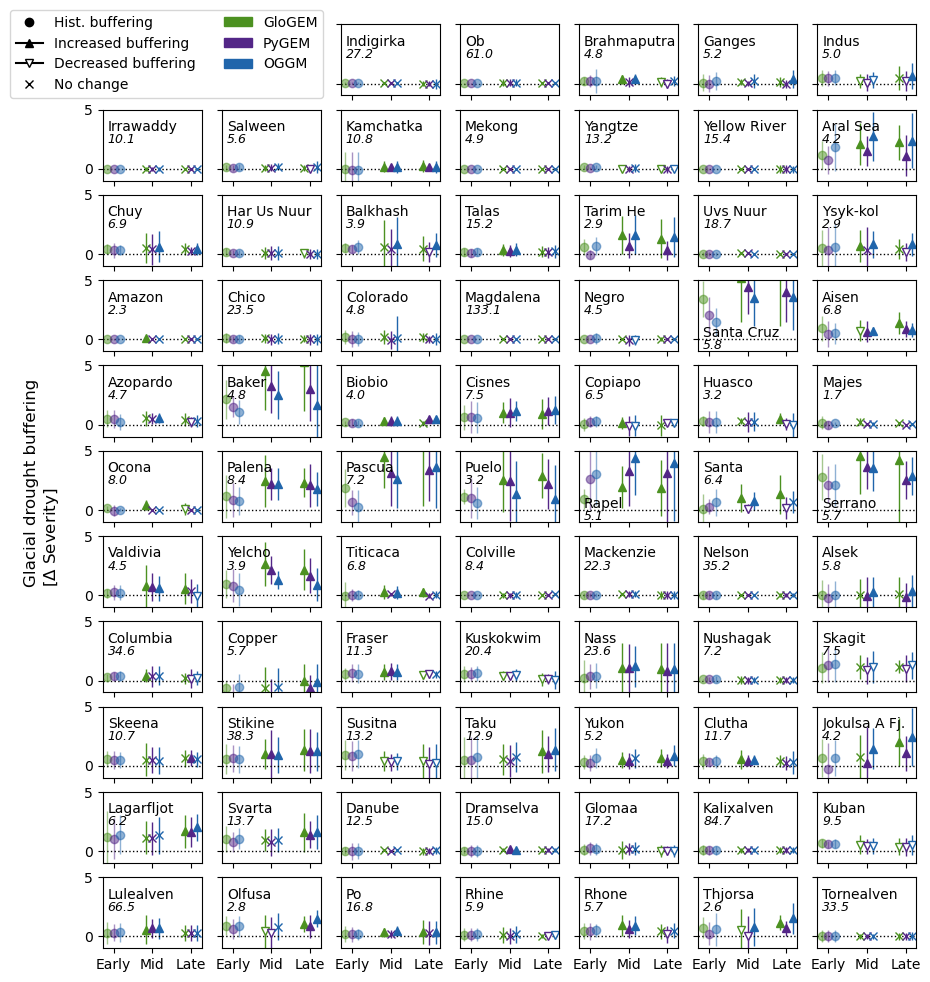

In [19]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

## Store statistics per basin
spread_by_basin = {b: [] for b in basin_names}


## Color defaults per model - diverging cmaps
colorcode = [ 'PiYG', 'PuOr', 'RdBu']
pos_spread = [-0.5, 0, 0.5]

fig,axs = plt.subplots(11,7, figsize=(10.5,12), sharex=True, sharey=True)
# axs_for_legend
for j, b in enumerate(basin_names):
    # pg = percent_glaciated.loc[b]
    ## just make a categorical plot instead,
    ## i.e. x-locations are 1, 2, 3 for early, mid, late century
    
    ax=axs.ravel()[2::][j]
    basin_label = ' '.join([s.capitalize() for s in b.split(' ')])
    if basin_label=='Lake Balkhash':
        basin_label = 'Balkhash'
    elif basin_label=='Jokulsa A Fjollum':
        basin_label = 'Jokulsa A Fj.'
    else:
        pass

    ## Temporary frame to aggregate statistics
    gcm_spread = []
    gem_means = []
    
    for test_GEM, c, p in zip(gmodels, colorcode, pos_spread):
    
        this_cmap = plt.get_cmap(c)
        base_color = this_cmap(1.0)
        dec_color = this_cmap(-0.7)
        inc_color = this_cmap(0.9)
    
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[test_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[test_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[test_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[test_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[test_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[test_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[test_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[test_GEM][m][b][2][0]))
        
        ## Report some statistics
        gcm_spread.append(np.nanmax(severity_endC)-np.nanmin(severity_endC)) ## one for each GEM
        gem_means.append(np.nanmean(severity_endC))

        ## Color code changes over time
        midC_v_hist_n = np.nanmean(number_midC)-np.nanmean(number_b)
        if midC_v_hist_n >0.1: # buffering on number increasing
            midC_color_n=inc_color
            midC_marker_n='^'
        elif midC_v_hist_n<-0.1:
            midC_color_n=dec_color
            midC_marker_n='v'
        else:
            midC_color_n='k'
            midC_marker_n='o'
        endC_v_hist_n = np.nanmean(number_endC)-np.nanmean(number_b)
        if endC_v_hist_n >0.1:
            endC_color_n=inc_color
            endC_marker_n='^'
        elif endC_v_hist_n<-0.1:
            endC_color_n=dec_color
            endC_marker_n='v'
        else:
            endC_color_n='k'
            endC_marker_n='o'

        midC_v_hist_s = np.nanmean(severity_midC)-np.nanmean(severity_b)
        if midC_v_hist_s >0.1: # buffering on duration increasing
            # midC_color_s=inc_color
            midC_facecolor = inc_color
            midC_edgecolor = inc_color
            midC_marker_s='^'
        elif midC_v_hist_s<-0.1:
            midC_facecolor ='white'
            midC_edgecolor = inc_color
            midC_marker_s='v'
        else:
            # midC_color_s='k'
            # midC_marker_s='o'
            midC_facecolor = 'white'
            midC_edgecolor = inc_color
            midC_marker_s = 'x'
            
        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        if endC_v_hist_s >0.1:
            endC_facecolor = inc_color
            endC_edgecolor = inc_color
            endC_marker_s='^'
        elif endC_v_hist_s<-0.1:
            endC_facecolor = 'white'
            endC_edgecolor = inc_color
            endC_marker_s='v'
        else:
            endC_facecolor = 'white'
            endC_edgecolor = inc_color
            endC_marker_s='x'
            
        ## First column: historical
        ax.errorbar(1+p, np.nanmean(severity_b), 
                     yerr=np.asarray(np.nanmean(severity_b)-np.nanmin(severity_b), np.nanmax(severity_b)-np.nanmean(severity_b)).transpose(), 
                     color=inc_color, marker='o', lw=1.0,
                   alpha=0.5
                   )
        
        ## Second column: mid-c
        ax.errorbar(4+p, np.nanmean(severity_midC), 
                     yerr=np.asarray(np.nanmean(severity_midC)-np.nanmin(severity_midC), 
                                     np.nanmax(severity_midC)-np.nanmean(severity_midC)).transpose(), 
                    mec=midC_edgecolor, mfc=midC_facecolor, marker=midC_marker_s, 
                    ecolor=midC_edgecolor, lw=1.0)
        
        ## Third column: end of century
        ax.errorbar(7+p, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), 
                                     np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     mec=endC_edgecolor, mfc=endC_facecolor, marker=endC_marker_s, 
                    ecolor=endC_edgecolor, lw=1.0)
        
    ax.set(xticks=[1,4,7], xticklabels=['Early', 'Mid', 'Late'])
    
    ## Compute the spread so it can be annotated
    spread_by_basin[b] = [max(gcm_spread), max(gem_means)-min(gem_means), (max(gcm_spread))/(max(gem_means)-min(gem_means))]
    ratio = (max(gcm_spread))/(max(gem_means)-min(gem_means))
    if basin_label in ('Serrano', 'Santa Cruz', 'Rapel'):
        label_y = 0.2
        ratio_y = 0.03
        # label_y = 0.7
        # ratio_y = 0.53
    else:
        label_y = 0.7
        ratio_y = 0.53
    ax.text(0.05, label_y, basin_label, transform=ax.transAxes)
    ax.text(0.05, ratio_y, '{:.1f}'.format(ratio), style='italic', fontsize=9, transform=ax.transAxes)


hist_marker = mlines.Line2D([], [], color='k', marker='o',
                          linestyle='None', 
                                label='Hist. buffering') 
        
increase_marker = mlines.Line2D([], [], color='k', marker='^',
                          # linestyle='None', 
                                label='Increased buffering') 

decrease_marker = mlines.Line2D([], [], mfc='white', mec='k', marker='v', color='k',
                          # linestyle='None', 
                                label='Decreased buffering')

nochange_marker = mlines.Line2D([], [], color='k', marker='x',
                          linestyle='None', 
                                label='No change') 
        
patches=[]
for p in [hist_marker, increase_marker, decrease_marker, nochange_marker]:
    patches.append(p)
for g, c in zip(gmodels, colorcode):        
    patches.append(mpatches.Patch(color=plt.get_cmap(c)(0.9), label=g))
    # purple_patch = mpatches.Patch(color=colorcode[1](0.9), label='PyGEM') 
    # blue_patch = mpatches.Patch(color=colorcode[3](0.9), label='OGGM')
axs[0,2].legend(handles=patches, bbox_to_anchor=(-0.11, 1.3), ncol=2)
## put legend in the empty space at the bottom or top?

[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()] ## remove "leftover" axes with no data
# for ax in axs[11,3:6]:
#     ax.set(xticks=[1,4,7], xticklabels=['Early', 'Mid', 'Late'])

for ax in axs.ravel():
    ax.axhline(0, ls=':', lw=1.0, color='k')
    ax.set(ylim=(-1,5))

axs[0,2].set(yticks=[0,5], yticklabels=[0,5], visible=True)

    
fig.supylabel('Glacial drought buffering \n'+ r'[$\Delta$ Severity]', x=0.05)
# fig.suptitle('21st century drought buffering by GEM and by basin (12 GCMs)')
# fig.supxlabel('21st century period')
plt.savefig('/Users/eultee/Desktop/{}-75basin-drought_buffering_severity-annotated.png'.format(datetime.date.today()))

## Single basin example for proposal
27 Mar 25 request by SC for Rhone only, with custom axes limits to better show this basin's data

End-century spread among GCMs: 0.3858973766616547
End-century multi-GCM mean for GloGEM: -0.009758533759869065
End-century spread among GCMs: 0.27173342420375857
End-century multi-GCM mean for PyGEM: 0.010531711675692485
End-century spread among GCMs: 0.8127592538534056
End-century multi-GCM mean for OGGM: 0.05534584523647925
Max GCM spread: 0.8127592538534056
Max GEM spread: 0.06510437899634831


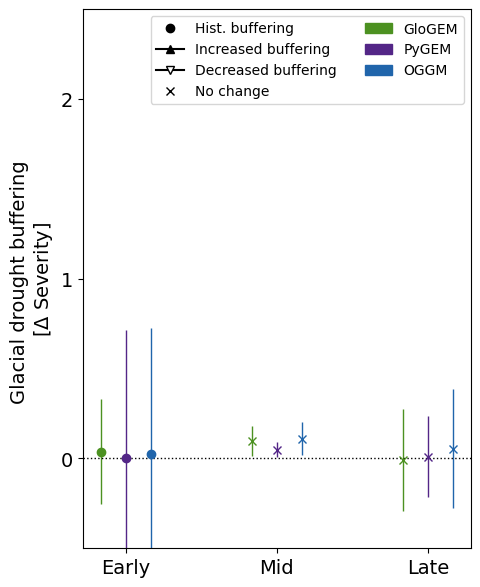

In [11]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import rcParams

highlight_basin = 'DANUBE'

## Color defaults per model - diverging cmaps
colorcode = [ 'PiYG', 'PuOr', 'RdBu']
pos_spread = [-0.5, 0, 0.5]

# rcParams["axes.titlesize"] = 22
rcParams["axes.labelsize"] = 14

fig,ax = plt.subplots(figsize=(5,7))
# axs_for_legend

basin_label = ' '.join([s.capitalize() for s in highlight_basin.split(' ')])
if basin_label=='Lake Balkhash':
    basin_label = 'Balkhash'
elif basin_label=='Jokulsa A Fjollum':
    basin_label = 'Jokulsa A Fj.'
else:
    pass

## Store some statistics to report
gcm_spread = []
gem_means = []

for test_GEM, c, p in zip(gmodels, colorcode, pos_spread):

    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(1.0)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)

    number_b = []
    severity_b = []
    number_midC = []
    number_endC = []
    severity_midC = []
    severity_endC = []

    for m in modelnames:
        number_b.append(basin_stats_bymodel_early[test_GEM][m][highlight_basin][0][1]
                        -basin_stats_bymodel_early[test_GEM][m][highlight_basin][0][0])
        number_midC.append(basin_stats_bymodel_midC[test_GEM][m][highlight_basin][0][1]
                           -basin_stats_bymodel_midC[test_GEM][m][highlight_basin][0][0])
        number_endC.append(basin_stats_bymodel_endC[test_GEM][m][highlight_basin][0][1]
                           -basin_stats_bymodel_endC[test_GEM][m][highlight_basin][0][0])
        severity_b.append(-1*(basin_stats_bymodel_early[test_GEM][m][highlight_basin][2][1]
                              -basin_stats_bymodel_early[test_GEM][m][highlight_basin][2][0]))
        severity_midC.append(-1*(basin_stats_bymodel_midC[test_GEM][m][highlight_basin][2][1]
                                 -basin_stats_bymodel_midC[test_GEM][m][highlight_basin][2][0]))
        severity_endC.append(-1*(basin_stats_bymodel_endC[test_GEM][m][highlight_basin][2][1]
                                 -basin_stats_bymodel_endC[test_GEM][m][highlight_basin][2][0]))

    ## Color code changes over time
    midC_v_hist_n = np.nanmean(number_midC)-np.nanmean(number_b)
    if midC_v_hist_n >0.1: # buffering on number increasing
        midC_color_n=inc_color
        midC_marker_n='^'
    elif midC_v_hist_n<-0.1:
        midC_color_n=dec_color
        midC_marker_n='v'
    else:
        midC_color_n='k'
        midC_marker_n='o'
    endC_v_hist_n = np.nanmean(number_endC)-np.nanmean(number_b)
    if endC_v_hist_n >0.1:
        endC_color_n=inc_color
        endC_marker_n='^'
    elif endC_v_hist_n<-0.1:
        endC_color_n=dec_color
        endC_marker_n='v'
    else:
        endC_color_n='k'
        endC_marker_n='o'

    midC_v_hist_s = np.nanmean(severity_midC)-np.nanmean(severity_b)
    if midC_v_hist_s >0.1: # buffering on duration increasing
        # midC_color_s=inc_color
        midC_facecolor = inc_color
        midC_edgecolor = inc_color
        midC_marker_s='^'
    elif midC_v_hist_s<-0.1:
        midC_facecolor ='white'
        midC_edgecolor = inc_color
        midC_marker_s='v'
    else:
        # midC_color_s='k'
        # midC_marker_s='o'
        midC_facecolor = 'white'
        midC_edgecolor = inc_color
        midC_marker_s = 'x'

    endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
    if endC_v_hist_s >0.1:
        endC_facecolor = inc_color
        endC_edgecolor = inc_color
        endC_marker_s='^'
    elif endC_v_hist_s<-0.1:
        endC_facecolor = 'white'
        endC_edgecolor = inc_color
        endC_marker_s='v'
    else:
        endC_facecolor = 'white'
        endC_edgecolor = inc_color
        endC_marker_s='x'

    ## First column: historical
    ax.errorbar(1+p, np.nanmean(severity_b), 
                 yerr=np.asarray(np.nanmean(severity_b)-np.nanmin(severity_b), np.nanmax(severity_b)-np.nanmean(severity_b)).transpose(), 
                 color=inc_color, marker='o', lw=1.0)

    ## Second column: mid-c
    ax.errorbar(4+p, np.nanmean(severity_midC), 
                 yerr=np.asarray(np.nanmean(severity_midC)-np.nanmin(severity_midC), 
                                 np.nanmax(severity_midC)-np.nanmean(severity_midC)).transpose(), 
                mec=midC_edgecolor, mfc=midC_facecolor, marker=midC_marker_s, 
                ecolor=midC_edgecolor, lw=1.0)

    ## Third column: end of century
    ax.errorbar(7+p, np.nanmean(severity_endC), 
                 yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), 
                                 np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                 mec=endC_edgecolor, mfc=endC_facecolor, marker=endC_marker_s, 
                ecolor=endC_edgecolor, lw=1.0)

    ## Report some statistics
    gcm_spread.append(np.nanmax(severity_endC)-np.nanmin(severity_endC)) ## one for each GEM
    gem_means.append(np.nanmean(severity_endC))
    print('End-century spread among GCMs: {}'.format(np.nanmax(severity_endC)-np.nanmin(severity_endC)))
    print('End-century multi-GCM mean for {}: {}'.format(test_GEM, np.nanmean(severity_endC)))

    # ax.text(0.05, 0.7, basin_label, fontsize=14, transform=ax.transAxes)
    ax.set(xticks=[1,4,7], xticklabels=['Early', 'Mid', 'Late'])


hist_marker = mlines.Line2D([], [], color='k', marker='o',
                          linestyle='None', 
                                label='Hist. buffering') 
        
increase_marker = mlines.Line2D([], [], color='k', marker='^',
                          # linestyle='None', 
                                label='Increased buffering') 

decrease_marker = mlines.Line2D([], [], mfc='white', mec='k', marker='v', color='k',
                          # linestyle='None', 
                                label='Decreased buffering')

nochange_marker = mlines.Line2D([], [], color='k', marker='x',
                          linestyle='None', 
                                label='No change') 
        
patches=[]
for p in [hist_marker, increase_marker, decrease_marker, nochange_marker]:
    patches.append(p)
for g, c in zip(gmodels, colorcode):        
    patches.append(mpatches.Patch(color=plt.get_cmap(c)(0.9), label=g))
    # purple_patch = mpatches.Patch(color=colorcode[1](0.9), label='PyGEM') 
    # blue_patch = mpatches.Patch(color=colorcode[3](0.9), label='OGGM')
ax.legend(handles=patches, 
          # bbox_to_anchor=(-0.11, 1.3), 
          ncol=2,
         loc='best')
## put legend in the empty space at the bottom or top?


ax.axhline(0, ls=':', lw=1.0, color='k')
ax.set(ylim=(-0.5,2.5),
       yticks=[0,1,2], 
       yticklabels=[0,1,2], visible=True,
      ylabel='Glacial drought buffering \n'+ r'[$\Delta$ Severity]')

plt.tick_params(axis='both', labelsize=14)  
# fig.supylabel('Glacial drought buffering \n'+ r'[$\Delta$ Severity]', x=0.05)
# fig.suptitle('21st century drought buffering by GEM and by basin (12 GCMs)')
# fig.supxlabel('21st century period')
# plt.savefig('/Users/lizz/Desktop/{}-75basin-drought_buffering_severity.png'.format(datetime.date.today()))

print('Max GCM spread: {}'.format(max(gcm_spread)))
print('Max GEM spread: {}'.format(max(gem_means)-min(gem_means)))